# Introduction
Here, we will use Lantern to implement a reverse image search. That is, given an image, we will return images that are "similar" to that image from a collection of images that we index.

The images we will be indexing will be a subset of the [ImageNet dataset](https://www.image-net.org/).

To generate the image embeddings, we will use the `MobileNetV2` model, using the `towhee` python library.

If you are running this in a colab, note that enabling a gpu-enabled runtime will be faster when we compute the embeddings. A cpu runtime will take significantly longer.

# Setup Postgres

We install postgres and its dev tools (necessary to build lantern from source). We also start postgres, and set up a user 'postgres' with password 'postgres' and create a database called 'ourdb'




In [ ]:
# We install postgres and its dev tools
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql postgresql-server-dev-all
#  Start postgres
!sudo service postgresql start

# Create user, password, and db
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS ourdb;'
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE ourdb;'

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 26.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package logrotate.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../00-logrotate_3.19.0-1ubuntu1.1_amd64.deb ...
Unpacking logrotate (3.19.0-1ubuntu1.1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../01-netbase_6.3_all.deb ...
Unpacking netbase (6.3) ...
Selecting previously unselected package python3-yaml.
Preparing to unpack .../02-python3-yaml_5.4.1-1ubuntu1_amd64.deb ...
Unpacking python3-yaml (5.4.1-1ubuntu1) ...
Selecting previous

# Install Lantern and build it from source

In [ ]:
!git clone --recursive https://github.com/lanterndata/lantern.git

Cloning into 'lantern'...
remote: Enumerating objects: 2562, done.
remote: Counting objects: 100% (1342/1342), done.
remote: Compressing objects: 100% (414/414), done.
remote: Total 2562 (delta 1068), reused 1003 (delta 922), pack-reused 1220
Receiving objects: 100% (2562/2562), 578.18 KiB | 1.21 MiB/s, done.
Resolving deltas: 100% (1698/1698), done.
Submodule 'third_party/hnswlib' (https://github.com/ngalstyan4/hnswlib) registered for path 'third_party/hnswlib'
Submodule 'third_party/usearch' (https://github.com/ngalstyan4/usearch) registered for path 'third_party/usearch'
Cloning into '/content/lantern/third_party/hnswlib'...
remote: Enumerating objects: 1723, done.        
remote: Counting objects: 100% (333/333), done.        
remote: Compressing objects: 100% (40/40), done.        
remote: Total 1723 (delta 306), reused 293 (delta 293), pack-reused 1390        
Receiving objects: 100% (1723/1723), 530.50 KiB | 23.06 MiB/s, done.
Resolving deltas: 100% (1097/1097), done.
Cloning in

In [ ]:
# We build lantern from source
%cd lantern
!mkdir build
%cd build
!pwd
!cmake ..
!make install

/content/lantern
/content/lantern/build
/content/lantern/build
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Build type: 
-- Found pg_config as /usr/bin/pg_config
-- Found postgres binary at /usr/lib/postgresql/14/bin/postgres
-- P

# Installing other Dependencies

In [ ]:
!python -m pip install -q towhee opencv-python pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.0/222.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.5 MB/s eta 0:00:00


### Downloading Image Data

The example image data (from ImageNet) we will use can be found on [Github](https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip).

That data is organized as follows:

  `train`: directory of candidate images, 10 images per class from ImageNet train data

  `test`: directory of query images, 1 image per class from ImageNet test data

  `reverse_image_search.csv`: a csv file containing id, path, and label for each candidate image

Let's download it:

In [ ]:
%cd /content
!pwd
!curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip -O
!unzip -q -o reverse_image_search.zip

/content
/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  67.9M      0  0:00:01  0:00:01 --:--:--  104M


### Configuration

Let's import our dependencies and set up some configuration variables:

In [ ]:
import csv
from glob import glob
from pathlib import Path
from statistics import mean

from towhee import pipe, ops, DataCollection

# Towhee parameters
MODEL = 'mobilenetv2_100'
DEVICE = None # if None, use default device (cuda is enabled if available)

# Path to csv (column_1 indicates image path) OR a pattern of image paths
INSERT_SRC = './reverse_image_search.csv'
QUERY_SRC = './test/*/*.JPEG'

# Embedding Pipeline

Let's see how we will turn images into embeddings. These embeddings are precisely the vectors that we will insert into Lantern later, and will perform vector search over to find the most "similar" images to some query image.

This is how we will use the MobileNetV2 model we specified earlier to generate these embeddings:

In [ ]:
# Load image path
def load_image(x):
    if x.endswith('csv'):
        with open(x) as f:
            reader = csv.reader(f)
            next(reader)
            for item in reader:
                yield item[1]
    else:
        for item in glob(x):
            yield item

# Embedding pipeline
p_embed = (
    pipe.input('src')
        .flat_map('src', 'img_path', load_image)
        .map('img_path', 'img', ops.image_decode())
        .map('img', 'vec', ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
)

Let's see an example embedding result. Note that the result vector has a shape of 1280, and so this is the dimensionality of the vectors we will insert into Lantern

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

img_path,img,vec
./test/goldfish/n01443537_3883.JPEG,,"[0.0, 0.0, 0.0, ...] shape=(1280,)"

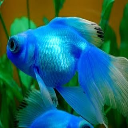

In [ ]:
# Display example embedding result
p_display = p_embed.output('img_path', 'img', 'vec')
DataCollection(p_display('./test/goldfish/*.JPEG')).show()



# Create Postgres Table

Now let's set up `psycopg2` with postgres, and enable the lantern extension


In [ ]:
import psycopg2

# We use the dbname, user, and password that we specified above
conn = psycopg2.connect(
    dbname="ourdb",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432" # default port for Postgres
)

# Get a new cursor
cursor = conn.cursor()

# Execute the query to load the Lantern extension in
cursor.execute("CREATE EXTENSION IF NOT EXISTS lantern;")

conn.commit()
cursor.close()

Now let's create the table that we will use to store these embeddings. We'll call the table `images_search`, and it will have a primary key `id`, the path of the image on our filesystem `path`, and the embedding for the image `vector`. Note that we make `vector` of type real array (`real[]`). We can add a dimension, like `real[2048]`, but note that this dimension specified here is just syntactic sugar in postgres, and is not enforced.

In [ ]:
# Create the table
cursor = conn.cursor()

TABLE_NAME = "images_search"

create_table_query = f"CREATE TABLE {TABLE_NAME} (id serial PRIMARY key, path text, vector real[]);"

cursor.execute(create_table_query)

conn.commit()
cursor.close()

# Inserting image embeddings into our database
Now that we have a table created, let's create and insert the embeddings for the images we have specified in `reverse_image_search.csv`.

Note that the majority of the time spent here is on computing the embeddings for the images.

Let's specify the insert pipeline we will use and run it:

In [ ]:

cursor = conn.cursor()

# Inserts a single image into our database
def single_insert(img_path, vec):
    vector = [float(x) for x in vec]
    cursor.execute(f"INSERT INTO {TABLE_NAME}(path, vector) VALUES (%s, %s);", (img_path, vector))


# Insert pipeline
p_insert = (
    p_embed.map(('img_path', 'vec'), 'mr', single_insert)
    .output('mr')
)

p_insert(INSERT_SRC)

conn.commit()
cursor.close()


# Creating an Index
Now that we have inserted the embeddings into our database, we need to construct an index in postgres using lantern. This is important because the index will tell allow postgres to use lantern when performing vector search.

Note that we use L2-squared (squared Euclidean distance) as the distance metric. Also, as a good practice, we specify the dimension of the vectors in the index (although lantern can infer it from the vectors we've already inserted).

In [ ]:
cursor = conn.cursor()

cursor.execute(f"CREATE INDEX ON {TABLE_NAME} USING hnsw (vector dist_l2sq_ops) WITH (dim=1280);")

conn.commit()
cursor.close()

# Performing Similarity Search

Now that we have embedded our images, we can now perform vector search amongst our images and find similar images this way.

Let's define a search pipeline that we will use. We will return the 10 images that are closest to our query image, and display their paths.

In [ ]:
cursor = conn.cursor()

def single_search(vec):
  query_vec = str([float(x) for x in vec])
  cursor.execute(f"SELECT path, cos_dist(vector, ARRAY{query_vec}) AS dist FROM {TABLE_NAME} ORDER BY vector <-> ARRAY{query_vec} LIMIT 10;")
  results = cursor.fetchall()
  return results


# Search pipeline
p_search_pre = (
        p_embed.map('vec', ('search_res'), single_search)
               .map('search_res', 'pred', lambda x: [str(Path(y[0]).resolve()) for y in x])
)
p_search = p_search_pre.output('img_path', 'pred')

# Search for example query image(s)
dc = p_search('test/goldfish/*.JPEG')

# Display search results with image paths
DataCollection(dc).show()

#cursor.close()


img_path,pred
test/goldfish/n01443537_3883.JPEG,/content/train/goldfish/n01443537_2819.JPEG /content/train/goldfish/n01443537_7751.JPEG /content/train/goldfish/n01443537_19638.JPEG /content/train/goldfish/n01443537_1903.JPEG /content/train/goldfish/n01443537_1415.JPEG /content/train/goldfish/n01443537_2637.JPEG /content/train/flamingo/n02007558_21569.JPEG /content/train/goldfish/n01443537_7376.JPEG /content/train/flamingo/n02007558_9853.JPEG /content/train/flamingo/n02007558_2788.JPEG


Now let's see these images:

img,pred_images
,

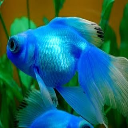
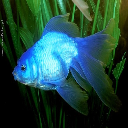
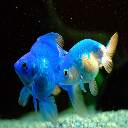
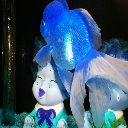
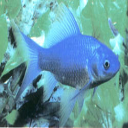
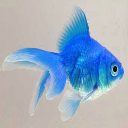
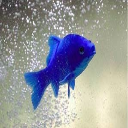
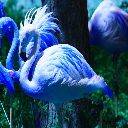
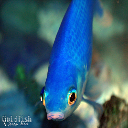
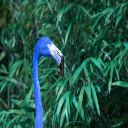
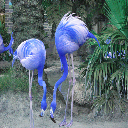

In [ ]:
import cv2
from towhee.types.image import Image

def read_images(img_paths):
    imgs = []
    for p in img_paths:
        imgs.append(Image(cv2.imread(p), 'BGR'))
    return imgs

p_search_img = (
    p_search_pre.map('pred', 'pred_images', read_images)
                .output('img', 'pred_images')
)
DataCollection(p_search_img('test/goldfish/*.JPEG')).show()

cursor.close()

# Conclusion
As we can see, the top 6 images are pictures of what our goldfish query picture is!

And that's how you can implement similarity search for questions using Lantern and an image embedding model.




### Cleanup

In [ ]:
# Close the postgres connection
conn.close()